# Lecture 3: Multivariate Time Series Relationships and Forecasting

**Goals of this Lecture:**

In previous lectures, you dealt with univariate time series—single variables evolving over time. However, many real-world phenomena involve multiple variables interacting and influencing each other. This lecture will introduce you to ways of assessing relationships and causal structures in multivariate time series, as well as extending forecasting methods to a multivariate context.

By the end of this lecture, you should be able to:

- **Section 1:** Load and visualize a multivariate time series dataset (five climate indices, including ENSO), and introduce the concept of correlation.  
  You will learn how to:
  - Understand correlation as a measure of linear relationship between variables.
  - Discuss the pros and cons of using correlation.
  - Derive practical insights and understand limitations.

- **Section 2:** Examine Granger Causality tests to assess whether one time series helps predict another.  
  You will learn:
  - The idea behind Granger causality and how to run the statistical test.
  - Pros and cons of Granger causality.
  - Practical insights and limitations.

- **Section 3:** Introduce Transfer Entropy as a more general measure of directional influence that does not rely solely on linear assumptions.  
  You will:
  - Understand the concept of Transfer Entropy (TE).
  - Discuss pros, cons, and limitations.
  - See a simplified estimation approach.

- **Section 4:** Implement a linear regression model for multivariate forecasting of ENSO using other climate indices as regressors.  
  You will learn:
  - How to split the data into train and test sets.
  - Fit a linear regression model.
  - Perform out-of-sample forecasts.
  - Visualize forecasts with confidence intervals.

- **Section 5:** Apply a Vector Autoregressive (VAR) model for multivariate forecasting.  
  You will:
  - Understand VAR and how it models multiple time series together.
  - Perform forecasting and visualize the results.

- **Section 6 (labeled as 5 in instructions, but we will correct to Section 6):** Compare models using various accuracy metrics, both for a simple out-of-sample forecast and a rolling forecast scenario.

As always, keep in mind the pros and cons of each method, and think critically about what information these tools provide and what they do not.


## SECTION 1: Loading Data, Visualization, and Correlation Analysis

You will start by loading a multivariate time series dataset: `combined_climate_indices_2024.csv`.
This dataset contains:

- **AAO**: Antarctic Oscillation Index  
- **AO**: Arctic Oscillation Index  
- **NAO**: North Atlantic Oscillation Index  
- **PNA**: Pacific North American Index  
- **ENSO**: El Niño–Southern Oscillation Index

**Why Correlation?**

Correlation measures the linear relationship between two variables. You may find it useful as a first step to see if two series tend to move together (positive correlation) or in opposite directions (negative correlation).

**Pros of Correlation:**
- Simple and widely understood.
- Quick to compute and interpret.
- Provides a first look at linear associations.

**Cons of Correlation:**
- Only measures linear relationships. Non-linear relationships might be missed.
- Does not imply causation. Just because two variables correlate does not mean one causes the other.
- Sensitive to outliers.

**Practical Insights:**
- If ENSO is strongly correlated with, say, PNA, you might guess that changes in PNA could help predict ENSO.
- A lack of correlation does not rule out more complex relationships.

After loading the data, you will visualize the time series and compute the correlation matrix. You need to carefully observe and discuss the patterns.


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
import warnings

warnings.filterwarnings('ignore')

sns.set()
plt.style.use('ggplot')


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def mase(y_true, y_pred, y_train):
    # mean(|y_t - y_hat_t|)/mean(|y_t - y_t-1|)
    numerator = np.mean(np.abs(y_true - y_pred))
    denominator = np.mean(np.abs(np.diff(y_train)))
    return numerator / denominator


def max_error(y_true, y_pred):
    return np.max(np.abs(y_true - y_pred))



### Load the Dataset

The dataset has a "Date" column and then several climate indices. You will parse the date, set it as the index, and ensure it's time-series-friendly.


In [48]:
df = pd.read_csv('ETTh1.csv', parse_dates=['date'], dayfirst=False)
df = df.set_index('date').sort_index()

# Ensure we have a consistent frequency (Daily data assumed)
df = df.asfreq('D')  # Daily start frequency
df.interpolate(method='linear', inplace=True)  # If any missing, fill linearly

df.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
2016-07-02,5.224,3.081,2.701,1.315,2.437,1.523,21.104000
2016-07-03,10.382,5.425,7.604,2.310,2.955,1.675,29.334999
2016-07-04,9.913,5.894,6.254,2.630,3.015,1.858,21.667000
2016-07-05,11.989,5.626,8.777,2.949,3.198,1.980,25.958000


In [49]:
df.describe

<bound method NDFrame.describe of                  HUFL   HULL    MUFL   MULL   LUFL   LULL         OT
date                                                                
2016-07-01   5.827000  2.009   1.599  0.462  4.203  1.340  30.531000
2016-07-02   5.224000  3.081   2.701  1.315  2.437  1.523  21.104000
2016-07-03  10.382000  5.425   7.604  2.310  2.955  1.675  29.334999
2016-07-04   9.913000  5.894   6.254  2.630  3.015  1.858  21.667000
2016-07-05  11.989000  5.626   8.777  2.949  3.198  1.980  25.958000
...               ...    ...     ...    ...    ...    ...        ...
2018-06-22  12.860000  4.622   7.640  2.523  4.752  1.492   8.231000
2018-06-23  16.476999  6.765  12.117  4.335  4.356  1.249   5.346000
2018-06-24  14.267000  5.090   9.843  3.127  4.356  1.279   6.894000
2018-06-25  16.476999  6.631  12.224  4.158  4.447  1.340   8.723000
2018-06-26  18.152000  6.966  12.331  4.264  5.544  1.645   9.708000

[726 rows x 7 columns]>

### Visualize the Time Series

You may find it easier to understand the relationships by looking at their time evolution. Let's plot all indices over time.


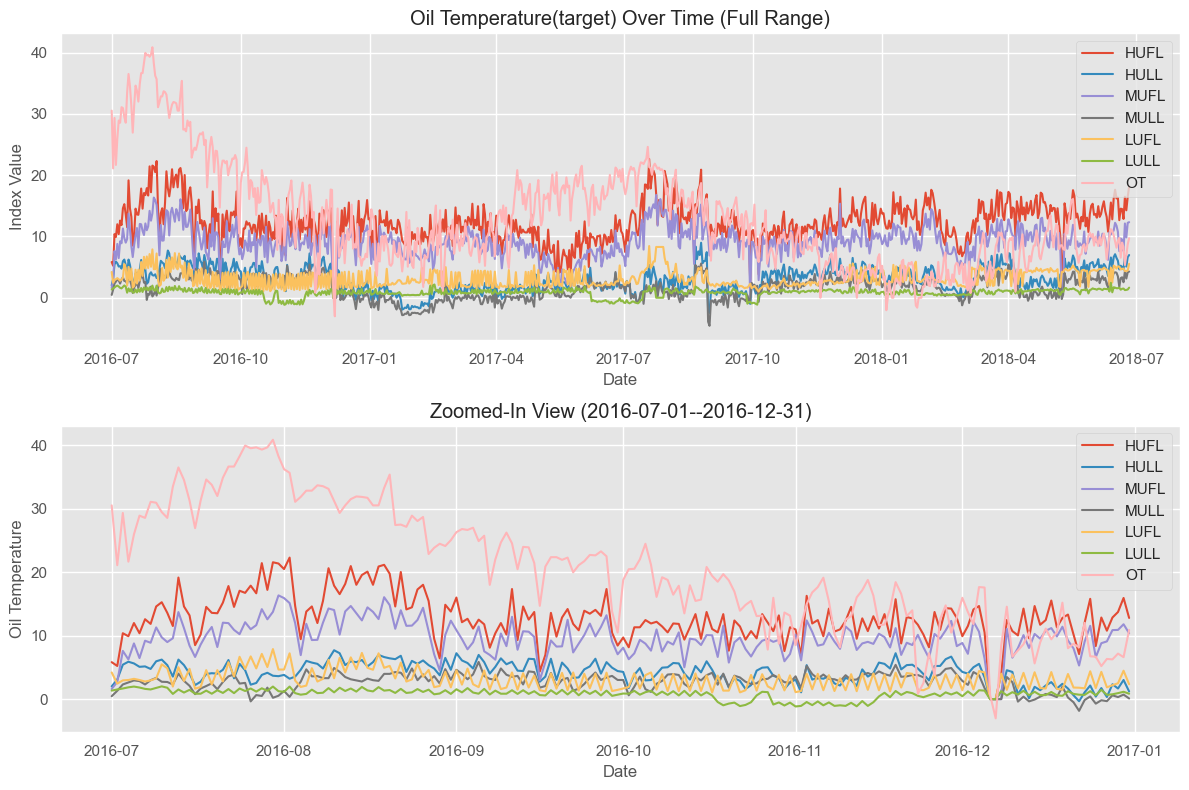

In [50]:
# ## Improved Visualization: Adding a Second Subplot for a Zoomed-In View
#
# You might find it helpful to see the entire time series at once to get a global understanding,
# but it’s often equally important to zoom in on a shorter date range to see more detail.
# Here, you will create a second subplot that focuses on a smaller time window,
# allowing you to see the variability and patterns more clearly.

fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# Top plot: Full Range
for col in df.columns:
    axs[0].plot(df.index, df[col], label=col)
axs[0].set_title("Oil Temperature(target) Over Time (Full Range)")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Index Value")
axs[0].legend()

# Bottom plot: Zoomed in on a specific range
# You may choose a period, for example, from 2000 to 2005.
zoom_start = '2016-07-01'
zoom_end = '2016-12-31'
zoom_df = df.loc[zoom_start:zoom_end]

for col in zoom_df.columns:
    axs[1].plot(zoom_df.index, zoom_df[col], label=col)
axs[1].set_title(f"Zoomed-In View ({zoom_start}--{zoom_end})")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Oil Temperature")
axs[1].legend()

plt.tight_layout()
plt.show()


**Discussion:**
- At a glance, you may see different patterns and fluctuations for each index.
- It's not immediately clear how they relate to each other. Some may have trends, some may oscillate.

### Correlation Matrix

Now let's compute the correlation matrix and visualize it as a heatmap.


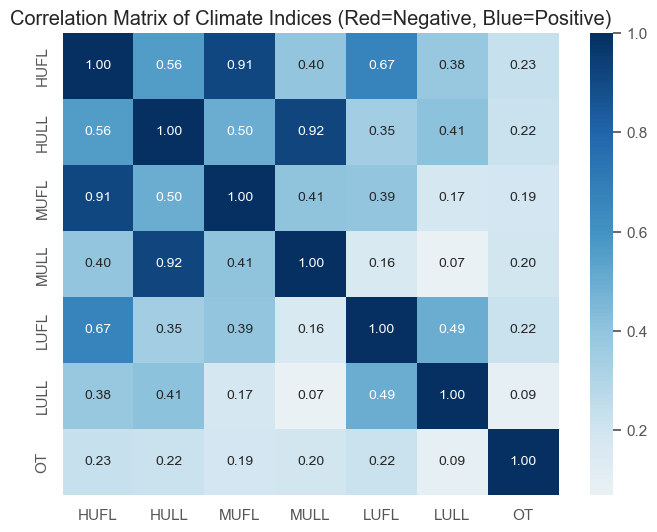

In [20]:
corr_matrix = df.corr()
plt.figure(figsize=(8, 6))
# The 'RdBu' colormap is a diverging colormap that shows negative values in red and positive values in blue.
# This aligns with your requirement: red for negatives and blue for positives.
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt=".2f", center=0)
plt.title("Correlation Matrix of Climate Indices (Red=Negative, Blue=Positive)")
plt.show()

**Interpreting the Correlation Matrix:**

- If a variable has a high positive correlation (close to 1) with ENSO, it means they move together linearly most of the time.
- If a variable has a negative correlation (close to -1) with ENSO, it suggests that when ENSO goes up, the other variable tends to go down, and vice versa.

**Remember:** Correlation does not imply causation, and it might be misleading if the relationship is non-linear or if there are confounding variables.


## SECTION 2: Granger Causality

**Why Granger Causality?**

Granger causality is a statistical method to test if past values of one time series contain information that helps predict future values of another series. In other words, if adding lagged values of variable X improves the forecast of variable Y, then X is said to "Granger cause" Y.

**Pros:**
- More sophisticated than just correlation.
- Provides a statistical test (based on regression and F-tests) for predictive ability.

**Cons:**
- Still assumes a linear relationship.
- "Granger cause" is not the same as true causation—it's about predictive content, not necessarily physical cause.
- Requires stationarity and careful selection of lags.

**Practical Insights:**
- If PNA Granger-causes ENSO, you may find including past PNA values improves ENSO forecasts.
- If no Granger causality is found, it doesn't mean no relationship exists, just that it wasn't detected by this linear test.

Let's test whether each of the other indices Granger causes ENSO. You need to pick a lag length. We'll try with a few lags and see if any significant result arises.


In [42]:
target = 'OT'
others = [col for col in df.columns if col != target]

# Choose a maximum lag
max_lag = 6

print("Granger Causality Tests (Does X cause ENSO?)\n")
for col in others:
    # Granger test expects a 2D array format: [endogenous, exogenous]
    # We'll test if col -> ENSO, so order of columns is [ENSO, col]
    data_test = df[[target, col]].dropna()
    # Run test
    result = grangercausalitytests(data_test, maxlag=max_lag, verbose=False)

    # Check p-values for the F-test from the last lag
    # You may choose based on specific lag or look at all
    # We'll just print the p-values for simplicity
    print(f"Variable tested: {col}")
    for lag in range(1, max_lag + 1):
        p_val = result[lag][0]['ssr_ftest'][1]
        print(f"Lag {lag} p-value: {p_val:.4f}")
    print("-" * 40)



Granger Causality Tests (Does X cause ENSO?)

Variable tested: HUFL
Lag 1 p-value: 0.1007
Lag 2 p-value: 0.1013
Lag 3 p-value: 0.2274
Lag 4 p-value: 0.0956
Lag 5 p-value: 0.2577
Lag 6 p-value: 0.2768
----------------------------------------
Variable tested: HULL
Lag 1 p-value: 0.8263
Lag 2 p-value: 0.4523
Lag 3 p-value: 0.2632
Lag 4 p-value: 0.2512
Lag 5 p-value: 0.2942
Lag 6 p-value: 0.1763
----------------------------------------
Variable tested: MUFL
Lag 1 p-value: 0.2206
Lag 2 p-value: 0.1171
Lag 3 p-value: 0.2245
Lag 4 p-value: 0.1173
Lag 5 p-value: 0.2336
Lag 6 p-value: 0.2319
----------------------------------------
Variable tested: MULL
Lag 1 p-value: 0.8806
Lag 2 p-value: 0.3120
Lag 3 p-value: 0.0959
Lag 4 p-value: 0.0973
Lag 5 p-value: 0.1257
Lag 6 p-value: 0.1149
----------------------------------------
Variable tested: LUFL
Lag 1 p-value: 0.2910
Lag 2 p-value: 0.4438
Lag 3 p-value: 0.7718
Lag 4 p-value: 0.8375
Lag 5 p-value: 0.8964
Lag 6 p-value: 0.8392
--------------------

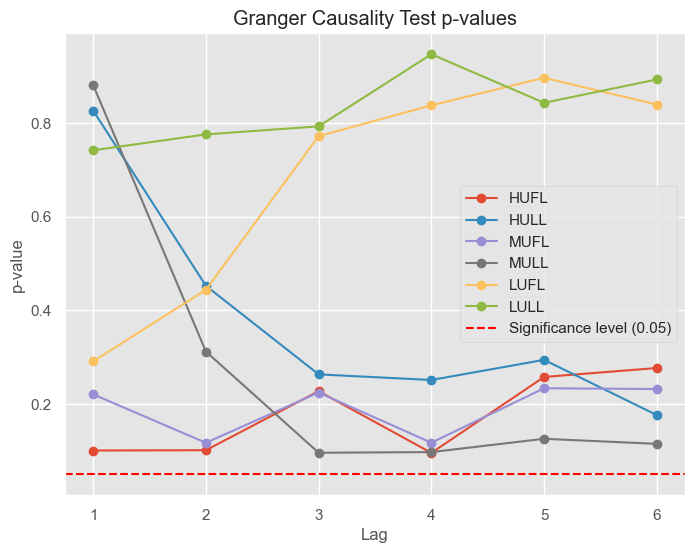

In [43]:
import matplotlib.pyplot as plt

# 这里示例使用你给出的 p-value 数据。
# 注意：LULL 的第 3 阶 p-value 未提供，暂用 None 或者手动填写一个占位值
variables = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]
p_values = [
    [0.1007, 0.1013, 0.2274, 0.0956, 0.2577, 0.2768],  # HUFL
    [0.8263, 0.4523, 0.2632, 0.2512, 0.2942, 0.1763],  # HULL
    [0.2206, 0.1171, 0.2245, 0.1173, 0.2336, 0.2319],  # MUFL
    [0.8806, 0.3120, 0.0959, 0.0973, 0.1257, 0.1149],  # MULL
    [0.2910, 0.4438, 0.7718, 0.8375, 0.8964, 0.8392],  # LUFL
    [0.7416, 0.7755, 0.7927, 0.9466, 0.8429, 0.8928],  # LULL
]

lags = range(1, 7)  # 1 到 6 阶

plt.figure(figsize=(8, 6))

for var, pvals in zip(variables, p_values):
    plt.plot(lags, pvals, marker='o', label=var)

# 绘制显著性水平参考线（如 0.05）
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance level (0.05)')

plt.xlabel('Lag')
plt.ylabel('p-value')
plt.title('Granger Causality Test p-values')
plt.legend()
plt.show()


**How to interpret the results:**
- If the p-value for a particular lag is low (e.g., below 0.05), it suggests that the variable in question provides statistically significant information to predict ENSO, according to the Granger causality definition.
- A low p-value in one or more lags might prompt you to include that variable's lagged values in a forecasting model for ENSO.

**Caveats:**
- Different lag selections can yield different conclusions.
- Granger causality does not prove a true physical or theoretical cause-and-effect relationship—only predictive capability.


## SECTION 3: Transfer Entropy

**Why Transfer Entropy (TE)?**

Transfer Entropy measures the reduction in uncertainty of one time series given the past of another. Unlike correlation or Granger causality (which are fundamentally linear/statistical tests), TE can capture non-linear and more complex directional influences.

**Pros:**
- Non-linear measure, not restricted to linear dependencies.
- Directional: can tell you whether X influences Y in a directional manner.

**Cons:**
- Computationally more expensive and complex to estimate.
- Requires careful choice of parameters (like embedding dimensions, binning strategies).
- Interpretation is not as straightforward as correlation or Granger causality.

**Practical Insights:**
- If TE from variable X to ENSO is high, you may find that knowing the past of X reduces uncertainty about ENSO's future.
- Low or zero TE suggests no additional predictive information.

**Note on Implementation:**
- There's no built-in TE function in standard Python libraries. You may need specialized libraries (e.g., `idtxl`) or implement your own estimation.
- Below is a simplified demonstration of TE estimation using a discrete binning approach. This is a conceptual demonstration, not a production-level implementation.


HUFL -> OT:
  lag=1, TE=0.0152
  lag=2, TE=0.0292
  lag=3, TE=0.0434
  lag=4, TE=0.0549
  lag=5, TE=0.0630
------------------------------
HULL -> OT:
  lag=1, TE=0.0126
  lag=2, TE=0.0207
  lag=3, TE=0.0266
  lag=4, TE=0.0301
  lag=5, TE=0.0330
------------------------------
MUFL -> OT:
  lag=1, TE=0.0146
  lag=2, TE=0.0291
  lag=3, TE=0.0446
  lag=4, TE=0.0564
  lag=5, TE=0.0642
------------------------------
MULL -> OT:
  lag=1, TE=0.0127
  lag=2, TE=0.0205
  lag=3, TE=0.0254
  lag=4, TE=0.0303
  lag=5, TE=0.0332
------------------------------
LUFL -> OT:
  lag=1, TE=0.0098
  lag=2, TE=0.0148
  lag=3, TE=0.0188
  lag=4, TE=0.0249
  lag=5, TE=0.0293
------------------------------
LULL -> OT:
  lag=1, TE=0.0137
  lag=2, TE=0.0198
  lag=3, TE=0.0266
  lag=4, TE=0.0318
  lag=5, TE=0.0340
------------------------------


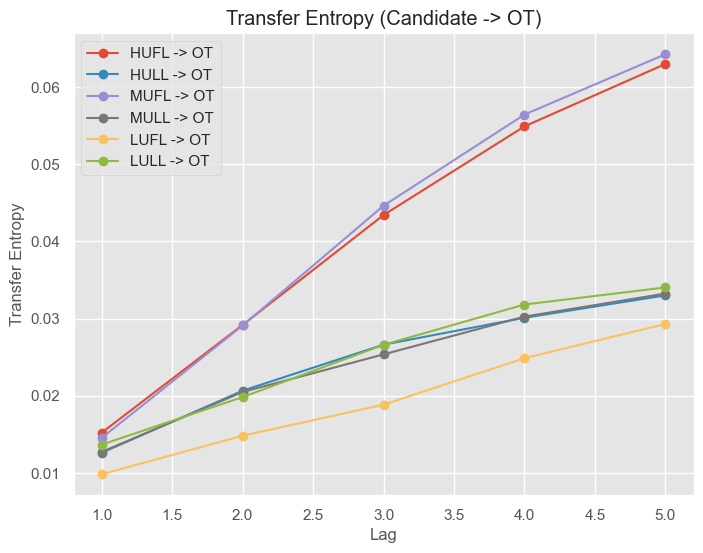

In [44]:
def transfer_entropy(x, y, bins=8, lag=1):
    """
    A simplified and not fully rigorous Transfer Entropy estimation.
    You need to remember this is for demonstration only.
    """
    # Shift y by the chosen lag
    y_lagged = np.roll(y, lag)
    y_lagged = y_lagged[lag:]
    x = x[lag:]
    y = y[lag:]

    # Discretize the data into bins
    x_bin = np.digitize(x, np.histogram(x, bins=bins)[1]) - 1
    y_bin = np.digitize(y, np.histogram(y, bins=bins)[1]) - 1
    y_lag_bin = np.digitize(y_lagged, np.histogram(y_lagged, bins=bins)[1]) - 1

    # Compute joint and conditional probabilities
    joint_xyy = np.zeros((bins, bins, bins))
    joint_xy = np.zeros((bins, bins))
    joint_yy = np.zeros((bins, bins))
    p_x = np.zeros(bins)
    p_y_lag = np.zeros(bins)
    p_y = np.zeros(bins)

    # Count occurrences
    for i in range(len(x_bin)):
        if (0 <= x_bin[i] < bins) and (0 <= y_bin[i] < bins) and (0 <= y_lag_bin[i] < bins):
            joint_xyy[x_bin[i], y_lag_bin[i], y_bin[i]] += 1
            joint_xy[x_bin[i], y_lag_bin[i]] += 1
            joint_yy[y_lag_bin[i], y_bin[i]] += 1
            p_x[x_bin[i]] += 1
            p_y_lag[y_lag_bin[i]] += 1
            p_y[y_bin[i]] += 1

    # Convert counts to probabilities
    N = len(x_bin)
    joint_xyy /= N
    joint_xy /= N
    joint_yy /= N
    p_x /= N
    p_y_lag /= N
    p_y /= N

    # TE(Y->X) = sum p(x,y_t-1,y_t)*log( p(y_t|x,y_t-1) / p(y_t|y_t-1) )
    # = sum p(x,y_lag,y)*log [ p(x,y_lag,y)/p(x,y_lag)  /  (p(y_lag,y)/p(y_lag)) ]
    # = sum p(...) log [ p(x,y_lag,y)*p(y_lag)/p(x,y_lag)*p(y_lag,y) ]

    TE = 0.0
    for xi in range(bins):
        for yi_lag in range(bins):
            for yi in range(bins):
                if joint_xyy[xi, yi_lag, yi] > 0 and joint_xy[xi, yi_lag] > 0 and joint_yy[yi_lag, yi] > 0 and p_y_lag[
                    yi_lag] > 0:
                    TE += joint_xyy[xi, yi_lag, yi] * np.log2(
                        (joint_xyy[xi, yi_lag, yi] * p_y_lag[yi_lag]) / (joint_xy[xi, yi_lag] * joint_yy[yi_lag, yi]))

    return TE


# ========== 以下为示例的 EDA 调用 ==========

# 1. 数据读取与预处理
df = pd.read_csv('ETTh1.csv', parse_dates=['date'], dayfirst=False)
df = df.set_index('date').sort_index()

# 假设数据列包括：HUFL, HULL, MUFL, MULL, LUFL, LULL, OT
# OT 可能是我们要预测的目标变量，这里演示将其他列作为潜在的预测因子。

target_col = 'OT'
candidate_cols = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']

# 去除缺失值，或者做其他预处理（如插值）
df = df.dropna()

# 2. 循环计算 TE：比如我们想看看从每个 candidate -> target 的传输熵
lag_list = [1, 2, 3, 4, 5]  # 你可以根据需要改动
results = {}

for var in candidate_cols:
    x = df[var].values
    y = df[target_col].values
    
    te_values = []
    for lag in lag_list:
        te_val = transfer_entropy(x, y, bins=8, lag=lag)
        te_values.append(te_val)
    results[var] = te_values

# 3. 打印或可视化结果
# 打印每个变量在不同 lag 下的 TE 值
for var in results:
    print(f"{var} -> {target_col}:")
    for lag, val in zip(lag_list, results[var]):
        print(f"  lag={lag}, TE={val:.4f}")
    print("-" * 30)

# 4. 简单绘图示例
plt.figure(figsize=(8, 6))

for var in candidate_cols:
    plt.plot(lag_list, results[var], marker='o', label=f'{var} -> {target_col}')

plt.xlabel('Lag')
plt.ylabel('Transfer Entropy')
plt.title('Transfer Entropy (Candidate -> OT)')
plt.legend()
plt.show()


**Interpretation:**
- A higher value suggests that knowing past AO values reduces uncertainty in predicting ENSO.
- In practice, you would compare TE between different pairs and possibly different lags and binning strategies.

**Limitation:**
- This simplified calculation may not capture the complexity of real-world data.
- Proper TE analysis requires more sophisticated tools.


### Computing Transfer Entropy for All Variable Pairs

Previously, you computed the Transfer Entropy (TE) only from AO to ENSO.
Now, you will compute a TE matrix for all possible pairs of variables.
This will provide a broader picture: which indices provide predictive information about which other indices?

**Key Points:**
- TE is directional. TE(X->Y) may not equal TE(Y->X).
- A higher TE value suggests that knowing the past of the first variable reduces uncertainty about the future of the second.
- TE can be zero or close to zero if no predictive information is found.
- If you see a high TE value from, say, PNA to ENSO, you can suspect that PNA dynamics might help predict ENSO.

**Visualizing TE Matrix:**
- You will create a matrix where rows represent the source variable and columns represent the target variable.
- Each cell in the matrix will show the TE value from the row variable to the column variable.
- You will use a colormap to highlight which pairs have higher TE values.
- The diagonal (variable to itself) is not meaningful and will be set to NaN.

After computing, you will visualize the results in a heatmap. This approach is similar to the correlation matrix visualization, but now for a directional and potentially non-linear measure.


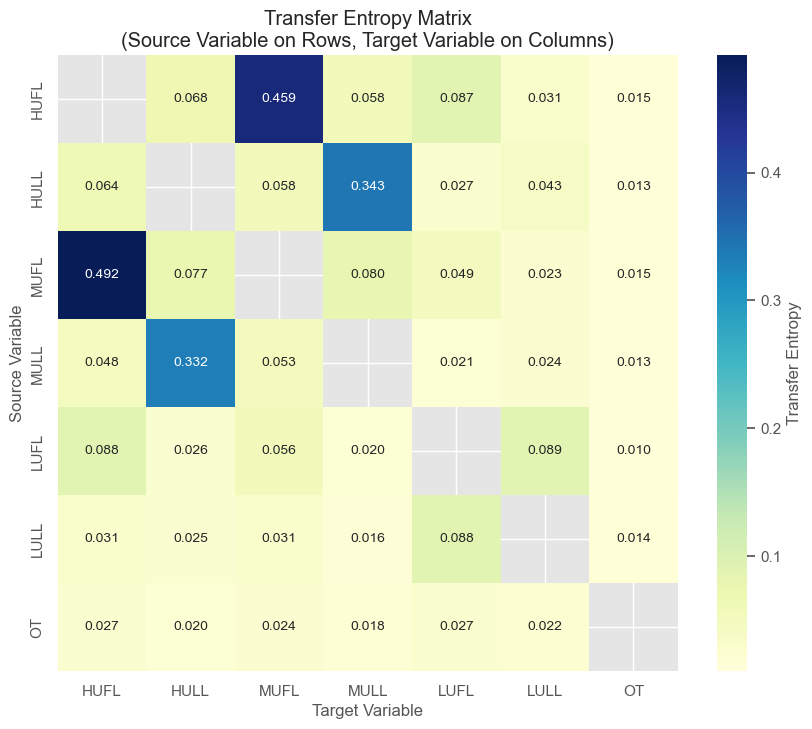

In [45]:
variables = df.columns.tolist()
te_matrix = pd.DataFrame(index=variables, columns=variables, dtype=float)

for source in variables:
    for target in variables:
        if source == target:
            te_matrix.loc[source, target] = np.nan  # Not meaningful to compute TE from a variable to itself
        else:
            x_data = df[source].values
            y_data = df[target].values
            te_val = transfer_entropy(x_data, y_data, bins=8, lag=1)
            te_matrix.loc[source, target] = te_val

plt.figure(figsize=(10, 8))
sns.heatmap(te_matrix, annot=True, fmt=".3f", cmap='YlGnBu', cbar_kws={'label': 'Transfer Entropy'})
plt.title("Transfer Entropy Matrix\n(Source Variable on Rows, Target Variable on Columns)")
plt.xlabel("Target Variable")
plt.ylabel("Source Variable")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


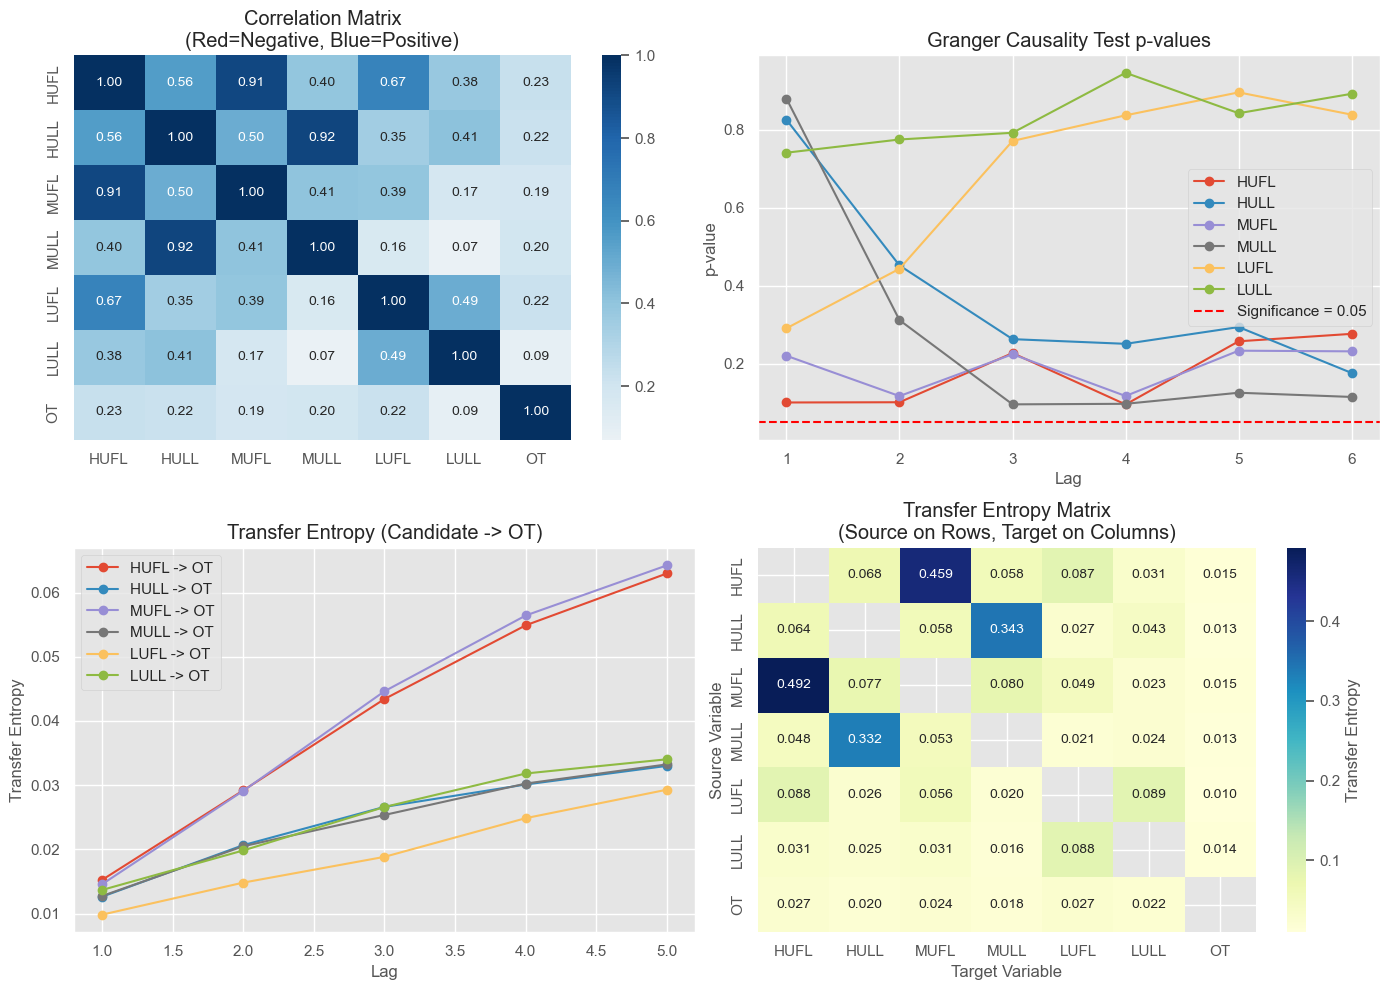

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===== 假设以下对象已准备完毕 =====
# corr_matrix   -> df.corr() 的结果
# variables, p_values, lags
# candidate_cols, results, lag_list, target_col
# te_matrix

# 创建 2x2 子图 (上下左右) 布局
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

########################################
# 子图(1,1): Correlation Heatmap
########################################
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt=".2f",
            center=0, ax=axes[0, 0])
axes[0, 0].set_title("Correlation Matrix\n(Red=Negative, Blue=Positive)")

########################################
# 子图(1,2): Granger Causality p-values
########################################
for var, pvals in zip(variables, p_values):
    axes[0, 1].plot(lags, pvals, marker='o', label=var)

# 绘制显著性水平参考线
axes[0, 1].axhline(y=0.05, color='red', linestyle='--', label='Significance = 0.05')
axes[0, 1].set_xlabel('Lag')
axes[0, 1].set_ylabel('p-value')
axes[0, 1].set_title('Granger Causality Test p-values')
axes[0, 1].legend()

########################################
# 子图(2,1): Transfer Entropy line plot
########################################
for var in candidate_cols:
    axes[1, 0].plot(lag_list, results[var], marker='o', label=f'{var} -> {target_col}')

axes[1, 0].set_xlabel('Lag')
axes[1, 0].set_ylabel('Transfer Entropy')
axes[1, 0].set_title('Transfer Entropy (Candidate -> OT)')
axes[1, 0].legend()

########################################
# 子图(2,2): Transfer Entropy Matrix
########################################
sns.heatmap(te_matrix, annot=True, fmt=".3f", cmap='YlGnBu',
            cbar_kws={'label': 'Transfer Entropy'}, ax=axes[1, 1])
axes[1, 1].set_title("Transfer Entropy Matrix\n(Source on Rows, Target on Columns)")
axes[1, 1].set_xlabel("Target Variable")
axes[1, 1].set_ylabel("Source Variable")

########################################
# 调整布局并保存为 EPS
########################################
plt.tight_layout()
plt.savefig('four_plots.eps', format='eps', dpi=300)
plt.show()


**Interpretation:**
- Look at each row: it shows how much each source variable reduces uncertainty about each target variable.
- If a particular cell (e.g., AO -> ENSO) shows a relatively high TE, it suggests that AO's past values contain informative signals that help predict ENSO.
- Compare directional pairs: For example, if TE(AO->ENSO) is larger than TE(ENSO->AO), it suggests a stronger predictive direction from AO to ENSO than vice versa.

**Caveats:**
- The TE computation here is simplistic. Real-world scenarios require more careful estimation and parameter selection.
- TE does not guarantee physical causation; it only indicates the presence of directional information flow.
- Use TE as a complementary tool along with other analyses, not as a standalone proof of causality.

## SECTION 4: Linear Regression for Multivariate Forecasting

Now that you have some idea about relationships and potential predictive variables, let's forecast ENSO using all other variables as regressors in a simple linear regression framework.

**Setup:**
- Use AAO, AO, NAO, PNA as regressors (independent variables).
- Use ENSO as the target (dependent variable).
- Perform a train/test split. For instance, use the first 80% of the data as train and the last 20% as test.
- Fit a linear model on the train data.
- Forecast out-of-sample using the test data regressors.

**Visualization:**
- Plot the entire ENSO series.
- Mark the train/test split with a vertical line.
- Show the in-sample fitted values on the train portion.
- Show the out-of-sample predictions on the test portion with a dashed line.
- Add 90% confidence bands for the forecast.

**Pros of Linear Regression:**
- Simple and fast.
- Easy to interpret the coefficients.

**Cons:**
- Only models linear relationships.
- Might not handle lagged dependencies directly unless you explicitly include them.
- No inherent way to model complex time-dependent patterns.

**Practical Insights:**
- This serves as a baseline multivariate forecasting approach.
- Real climate systems may be highly non-linear, so linear regression might be too simplistic.


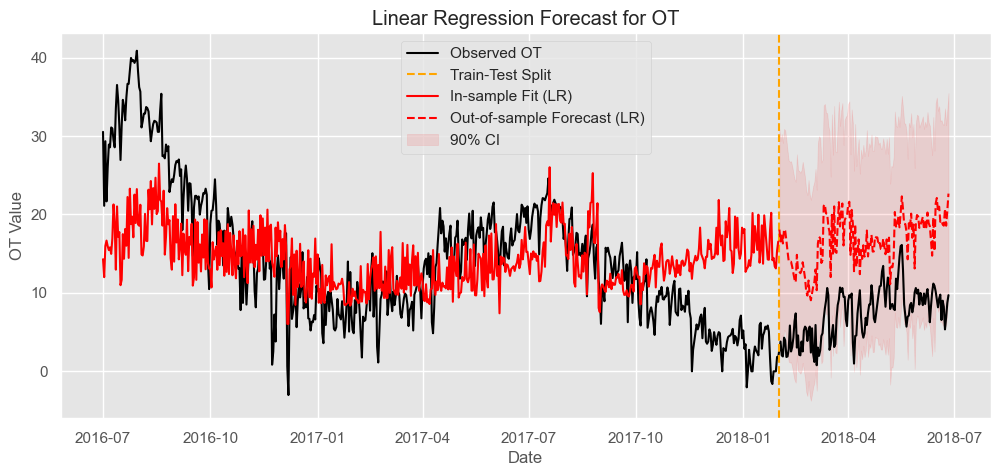

In [52]:
# Prepare data
target_col = 'OT'
X = df.drop(columns=[target_col])
y = df[target_col]

n = len(df)
train_size = int(n * 0.8)
train_X, test_X = X.iloc[:train_size], X.iloc[train_size:]
train_y, test_y = y.iloc[:train_size], y.iloc[train_size:]

# Fit linear regression
lr_model = LinearRegression()
lr_model.fit(train_X, train_y)

# In-sample fitted values
fitted_values = lr_model.predict(train_X)

# Out-of-sample forecast
forecast_values = lr_model.predict(test_X)

# Compute 90% CI for the forecast
# Assuming normal errors, CI = forecast ± z * std_err
# We'll estimate std_err from residuals in training set
residuals = train_y - fitted_values
std_res = np.std(residuals)
z_val = 1.645  # ~90% CI
lower_ci = forecast_values - z_val * std_res
upper_ci = forecast_values + z_val * std_res

# Visualization
plt.figure(figsize=(12, 5))
plt.plot(y.index, y.values, label='Observed OT', color='black')
plt.axvline(x=y.index[train_size], color='orange', linestyle='--', label='Train-Test Split')

# In-sample fitted
plt.plot(train_y.index, fitted_values, label='In-sample Fit (LR)', color='red')

# Out-of-sample forecast
plt.plot(test_y.index, forecast_values, label='Out-of-sample Forecast (LR)', color='red', linestyle='--')
plt.fill_between(test_y.index, lower_ci, upper_ci, color='red', alpha=0.1, label='90% CI')

plt.title("Linear Regression Forecast for OT")
plt.xlabel("Date")
plt.ylabel("OT Value")
plt.legend()
plt.show()


**Discussion:**
- The linear regression model may or may not capture the complexity of ENSO dynamics.
- The confidence interval gives you a sense of uncertainty, but it's based on the assumption of residual distribution and might be too simplistic.


## SECTION 5: VAR Model for Multivariate Forecasting

**Why VAR?**

A Vector Autoregressive (VAR) model captures the linear interdependencies among multiple variables. Each variable in a VAR model is a linear function of the past values of *all* variables in the system.

**Pros:**
- Models multiple time series simultaneously.
- Can capture feedback loops: how ENSO depends on AO and how AO depends on ENSO, etc.

**Cons:**
- Still linear.
- Requires stationarity or differencing if non-stationary.
- Many parameters to estimate, can lead to overfitting if not careful.

**Practical Insights:**
- VAR might improve forecasts if the variables provide additional predictive information.
- You can choose the optimal VAR order based on criteria like AIC or BIC.

Let's fit a VAR model on all variables and forecast ENSO out-of-sample.


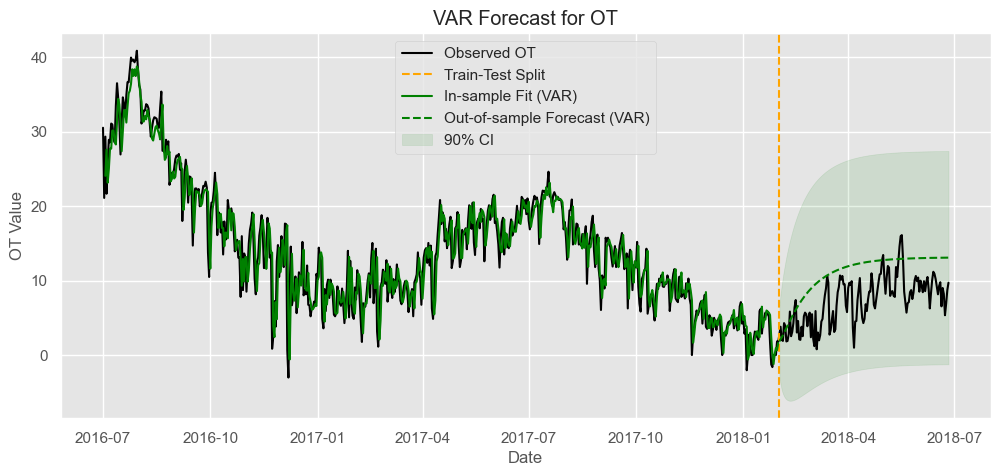

In [ ]:
# For VAR, we need a stationary or at least stable process. 
# Often you'd difference or transform. Here, for simplicity, we'll just use the raw data.
# In practice, you should check stationarity and differ if needed.

train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

model_var = VAR(train_df)
results_var = model_var.fit(maxlags=2)  # You can vary this lag

# Forecast the test period
lag_order = results_var.k_ar
input_data = train_df.values[-lag_order:]
var_forecast = results_var.forecast(input_data, steps=len(test_df))
var_forecast_df = pd.DataFrame(var_forecast, index=test_df.index, columns=df.columns)

# Extract the ENSO forecasts
enso_var_forecast = var_forecast_df[target_col]

# Compute 90% CI for VAR forecasts
# VAR results have covariance info for forecasts.
# We'll use the forecast_cov method, which only needs 'steps'.
fcst_cov = results_var.forecast_cov(steps=len(test_df))

# Extract diagonal corresponding to OT index.
enso_idx = df.columns.get_loc('OT')
std_enso = []
for i in range(len(test_df)):
    var_cov_matrix = fcst_cov[i]
    std_enso.append(np.sqrt(var_cov_matrix[enso_idx, enso_idx]))

std_enso = np.array(std_enso)
var_lower = enso_var_forecast - z_val * std_enso
var_upper = enso_var_forecast + z_val * std_enso

# In-sample fit for OT (pseudo in-sample predictions)
enso_in_sample = results_var.fittedvalues['OT'].reindex(train_df.index)

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['OT'], label='Observed OT', color='black')
plt.axvline(x=df.index[train_size], color='orange', linestyle='--', label='Train-Test Split')

plt.plot(enso_in_sample.index, enso_in_sample, label='In-sample Fit (VAR)', color='green')

plt.plot(test_df.index, enso_var_forecast, label='Out-of-sample Forecast (VAR)', color='green', linestyle='--')
plt.fill_between(test_df.index, var_lower, var_upper, color='green', alpha=0.1, label='90% CI')

plt.title("VAR Forecast for OT")
plt.xlabel("Date")
plt.ylabel("OT Value")
plt.legend()
plt.show()


**Discussion:**
- The VAR model incorporates information from all variables and their lags.
- This might improve forecasting accuracy if the relationships are linear and stable.
- As always, consider the model assumptions and complexity.


## SECTION 6: Accuracy Comparison for Simple and Rolling Forecasts

Now that you have two forecast methods (Linear Regression and VAR), you will compare their forecasting accuracy.

**Metrics:**
- **max_error**: The maximum absolute error.
- **MAE**: Mean Absolute Error.
- **MSE**: Mean Squared Error.
- **RMSE**: Root Mean Squared Error.
- **MAPE**: Mean Absolute Percentage Error.
- **MASE**: Mean Absolute Scaled Error.

You will:
1. Compute these metrics for the simple out-of-sample forecasts (just once, no rolling).
2. Implement a rolling forecast scenario for both models and compare metrics again.

**Rolling Forecast Procedure:**
- Start with the training set.
- Forecast one step ahead.
- Add the observed value to the training set (extend it by one) and re-fit the model.
- Repeat until you have forecasts for the entire test set.

This is more realistic, as in real-world scenarios you update your model as new data comes in.


In [55]:
# First, let's compute metrics for the simple forecast scenario
# We already have forecast_values (LR) and enso_var_forecast (VAR)
simple_metrics = pd.DataFrame(columns=["max_error", "MAE", "MSE", "RMSE", "MAPE", "MASE"], index=["LinearReg", "VAR"])

test_actual = test_y.values
test_train = train_y.values  # for MASE calculation

# For Linear Regression
simple_metrics.loc["LinearReg", "max_error"] = max_error(test_actual, forecast_values)
simple_metrics.loc["LinearReg", "MAE"] = mean_absolute_error(test_actual, forecast_values)
simple_metrics.loc["LinearReg", "MSE"] = mean_squared_error(test_actual, forecast_values)
simple_metrics.loc["LinearReg", "RMSE"] = rmse(test_actual, forecast_values)
simple_metrics.loc["LinearReg", "MAPE"] = mape(test_actual, forecast_values)
simple_metrics.loc["LinearReg", "MASE"] = mase(test_actual, forecast_values, test_train)

# For VAR
var_fc = enso_var_forecast.values
simple_metrics.loc["VAR", "max_error"] = max_error(test_actual, var_fc)
simple_metrics.loc["VAR", "MAE"] = mean_absolute_error(test_actual, var_fc)
simple_metrics.loc["VAR", "MSE"] = mean_squared_error(test_actual, var_fc)
simple_metrics.loc["VAR", "RMSE"] = rmse(test_actual, var_fc)
simple_metrics.loc["VAR", "MAPE"] = mape(test_actual, var_fc)
simple_metrics.loc["VAR", "MASE"] = mase(test_actual, var_fc, test_train)

print("Simple Out-of-Sample Forecasting Accuracy:")
print(simple_metrics)



Simple Out-of-Sample Forecasting Accuracy:
           max_error       MAE        MSE      RMSE        MAPE      MASE
LinearReg  17.935899  9.392129   98.84034  9.941848  200.043562  4.363714
VAR         11.15923  3.907238  20.359628  4.512164   90.957057  1.815357


### Rolling Forecasts

Let's implement rolling forecasts for both Linear Regression and VAR.
Note: This might be computationally more expensive.


In [56]:
def rolling_forecast_linear_reg(train, test, target_col):
    # We'll use a simple 1-step ahead rolling forecast
    history_X = train.drop(columns=[target_col]).copy()
    history_y = train[target_col].copy()

    forecasts = []
    for i in range(len(test)):
        # Fit the model on current history
        lr = LinearRegression()
        lr.fit(history_X, history_y)
        # Forecast the next step
        next_X = test.drop(columns=[target_col]).iloc[i:i + 1]
        fcast = lr.predict(next_X)[0]
        forecasts.append(fcast)
        # Update history with the observed test value
        history_X = pd.concat([history_X, next_X], axis=0)
        history_y = pd.concat([history_y, test[target_col].iloc[i:i + 1]])
    return np.array(forecasts)


def rolling_forecast_var(train, test):
    # Similarly for VAR
    history = train.copy()
    forecasts = []
    for i in range(len(test)):
        model = VAR(history)
        results = model.fit(maxlags=2)
        input_data = history.values[-results.k_ar:]
        fcast = results.forecast(input_data, steps=1)
        f_enso = fcast[0, enso_idx]
        forecasts.append(f_enso)

        # Update history with observed test row
        next_row = test.iloc[i:i + 1].copy()
        history = pd.concat([history, next_row])
    return np.array(forecasts)


rolling_lr_forecasts = rolling_forecast_linear_reg(train_df, test_df, target_col='OT')
rolling_var_forecasts = rolling_forecast_var(train_df, test_df)

rolling_metrics = pd.DataFrame(columns=["max_error", "MAE", "MSE", "RMSE", "MAPE", "MASE"], index=["LinearReg", "VAR"])
rolling_metrics.loc["LinearReg", "max_error"] = max_error(test_actual, rolling_lr_forecasts)
rolling_metrics.loc["LinearReg", "MAE"] = mean_absolute_error(test_actual, rolling_lr_forecasts)
rolling_metrics.loc["LinearReg", "MSE"] = mean_squared_error(test_actual, rolling_lr_forecasts)
rolling_metrics.loc["LinearReg", "RMSE"] = rmse(test_actual, rolling_lr_forecasts)
rolling_metrics.loc["LinearReg", "MAPE"] = mape(test_actual, rolling_lr_forecasts)
rolling_metrics.loc["LinearReg", "MASE"] = mase(test_actual, rolling_lr_forecasts, test_train)

rolling_metrics.loc["VAR", "max_error"] = max_error(test_actual, rolling_var_forecasts)
rolling_metrics.loc["VAR", "MAE"] = mean_absolute_error(test_actual, rolling_var_forecasts)
rolling_metrics.loc["VAR", "MSE"] = mean_squared_error(test_actual, rolling_var_forecasts)
rolling_metrics.loc["VAR", "RMSE"] = rmse(test_actual, rolling_var_forecasts)
rolling_metrics.loc["VAR", "MAPE"] = mape(test_actual, rolling_var_forecasts)
rolling_metrics.loc["VAR", "MASE"] = mase(test_actual, rolling_var_forecasts, test_train)

print("\nRolling Forecasting Accuracy:")
print(rolling_metrics)



Rolling Forecasting Accuracy:
           max_error       MAE        MSE      RMSE       MAPE      MASE
LinearReg  16.636338  7.826856  72.357478   8.50632  178.38491  3.636466
VAR         7.433545  1.556315   3.937513  1.984317  35.800529  0.723085


**Discussion:**
- Compare the metrics between simple and rolling forecasts.
- Rolling forecasts often provide a more realistic picture of how the model performs in practice.
- If VAR improves accuracy, it suggests that leveraging multivariate time dependencies is beneficial.
- If Linear Regression is comparable or better, it might mean that complexity doesn't necessarily guarantee better forecasts.

**Final Notes:**
- Correlation, Granger causality, and Transfer Entropy give you different lenses to understand relationships.
- For forecasting, you have many tools (Linear Regression, VAR, and more sophisticated models).
- Always validate assumptions and consider more complex (e.g., machine learning or deep learning) methods if linear models are insufficient.

You now have a broad overview of how to handle multivariate time series analysis and forecasting, including how to evaluate the relationships between variables and how to forecast one using others.
